# imports

In [20]:
from collections import Counter
from math import log, exp
import re
import os
import sys
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import nltk
import re
import heapq
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sn
import matplotlib.pyplot as plt

# parameters

In [2]:
ALPHA = 1.0
random_seed = 2020
input_data_dir = f'{os.getcwd()}\\option1-data'
output_data_dir = f'{os.getcwd()}\\submission-data'

# naive bayes model

In [3]:
class NaiveBayes:
    
    def __init__(self):
        
        self.word_count_agreed_1 = Counter()
        self.word_count_disagreed_1 = Counter()
        self.word_count_unrelated_1 = Counter()
                
        self.total_agreed_words_1 = 0
        self.total_disagreed_words_1 = 0
        self.total_unrelated_words_1 = 0
        
        self.word_count_agreed_2 = Counter()
        self.word_count_disagreed_2 = Counter()
        self.word_count_unrelated_2 = Counter()
        
        self.total_agreed_words_2 = 0
        self.total_disagreed_words_2 = 0
        self.total_unrelated_words_2 = 0
        
        self.num_agreed_match = 0
        self.num_disagreed_match = 0
        self.num_unrelated_match = 0
        
        self.p_agreed = 0.0
        self.p_disagreed = 0.0
        self.p_unrelated = 0.0
        
        self.vocab_1 = None
        self.vocab_2 = None
    
    def train(self, train_dataset=None, validation_dataset=None, alpha=None):
                        
        for index, row in train_dataset.iterrows():
            
            title1 = row['title1_en']
            title2 = row['title2_en']
            label = row['label']
            
            if label == 'agreed':
                self.num_agreed_match += 1
            elif label == 'disagreed':
                self.num_disagreed_match += 1
            elif label == 'unrelated':
                self.num_unrelated_match += 1
            
            corpus1 = nltk.sent_tokenize(title1)
            corpus2 = nltk.sent_tokenize(title2)
            
            for ind in range(len(corpus1)):
                corpus1[ind] = corpus1[ind].lower()
                corpus1[ind] = re.sub(r'\W', ' ', corpus1[ind])
                corpus1[ind] = re.sub(r'\s+', ' ', corpus1[ind])
            for ind in range(len(corpus2)):
                corpus2[ind] = corpus2[ind].lower()
                corpus2[ind] = re.sub(r'\W', ' ', corpus2[ind])
                corpus2[ind] = re.sub(r'\s+', ' ', corpus2[ind])
            
            for sentence in corpus1:
                tokens = nltk.word_tokenize(sentence)
                for token in tokens:
                    if label == 'agreed':
                        self.total_agreed_words_1 += 1
                        self.word_count_agreed_1[token] += 1
                    elif label == 'disagreed':
                        self.total_disagreed_words_1 += 1
                        self.word_count_disagreed_1[token] += 1
                    elif label == 'unrelated':
                        self.total_unrelated_words_1 += 1
                        self.word_count_unrelated_1[token] += 1
            for sentence in corpus2:
                tokens = nltk.word_tokenize(sentence)
                for token in tokens:
                    if label == 'agreed':
                        self.total_agreed_words_2 += 1
                        self.word_count_agreed_2[token] += 1
                    elif label == 'disagreed':
                        self.total_disagreed_words_2 += 1
                        self.word_count_disagreed_2[token] += 1
                    elif label == 'unrelated':
                        self.total_unrelated_words_2 += 1
                        self.word_count_unrelated_2[token] += 1
            
        self.vocab_1 = set(list(self.word_count_agreed_1.keys()) + list(self.word_count_disagreed_1.keys()) + list(self.word_count_unrelated_1.keys()))
        self.vocab_2 = set(list(self.word_count_agreed_2.keys()) + list(self.word_count_disagreed_2.keys()) + list(self.word_count_unrelated_2.keys()))

        self.p_agreed = log(float(self.num_agreed_match)) - log(float(self.num_agreed_match + self.num_disagreed_match + self.num_unrelated_match))
        self.p_disagreed = log(float(self.num_disagreed_match)) - log(float(self.num_agreed_match + self.num_disagreed_match + self.num_unrelated_match))
        self.p_unrelated = log(float(self.num_unrelated_match)) - log(float(self.num_agreed_match + self.num_disagreed_match + self.num_unrelated_match))
        
        validation_result = self.predict(test_dataset=validation_dataset, alpha=alpha)
        
        accuracy = np.sum(np.equal(validation_result['label'].to_numpy(), validation_dataset['label'].to_numpy())) / float(validation_result.shape[0])
        
        return accuracy
    
    def predict(self, test_dataset=None, alpha=None):
        
        pred = pd.DataFrame(columns = ['id', 'prob', 'label'], index = test_dataset.index.values.tolist())
        
        labels = ['agreed', 'disagreed', 'unrelated']
        
        for index, row in test_dataset.iterrows():
            
            id_instance = row['id']
            title1 = row['title1_en']
            title2 = row['title2_en']
            
            sum_agreed_1 = 0.0
            sum_disagreed_1 = 0.0
            sum_unrelated_1 = 0.0
            
            sum_agreed_2 = 0.0
            sum_disagreed_2 = 0.0
            sum_unrelated_2 = 0.0
            
            corpus1 = nltk.sent_tokenize(title1)
            corpus2 = nltk.sent_tokenize(title2)
            
            for ind in range(len(corpus1)):
                corpus1[ind] = corpus1[ind].lower()
                corpus1[ind] = re.sub(r'\W', ' ', corpus1[ind])
                corpus1[ind] = re.sub(r'\s+', ' ', corpus1[ind])
            for ind in range(len(corpus2)):
                corpus2[ind] = corpus2[ind].lower()
                corpus2[ind] = re.sub(r'\W', ' ', corpus2[ind])
                corpus2[ind] = re.sub(r'\s+', ' ', corpus2[ind])
            
            for sentence in corpus1:
                tokens = nltk.word_tokenize(sentence)
                for token in tokens:
                    sum_agreed_1 += log(float(self.word_count_agreed_1[token] + alpha) / float(self.total_agreed_words_1 + (alpha * len(self.vocab_1))))
                    sum_disagreed_1 += log(float(self.word_count_disagreed_1[token] + alpha) / float(self.total_disagreed_words_1 + (alpha * len(self.vocab_1))))
                    sum_unrelated_1 += log(float(self.word_count_unrelated_1[token] + alpha) / float(self.total_unrelated_words_1 + (alpha * len(self.vocab_1))))
            for sentence in corpus2:
                tokens = nltk.word_tokenize(sentence)
                for token in tokens:
                    sum_agreed_2 += log(float(self.word_count_agreed_2[token] + alpha) / float(self.total_agreed_words_2 + (alpha * len(self.vocab_2))))
                    sum_disagreed_2 += log(float(self.word_count_disagreed_2[token] + alpha) / float(self.total_disagreed_words_2 + (alpha * len(self.vocab_2))))
                    sum_unrelated_2 += log(float(self.word_count_unrelated_2[token] + alpha) / float(self.total_unrelated_words_2 + (alpha * len(self.vocab_2))))
            
            sum_agreed = sum_agreed_1 + sum_agreed_2 + self.p_agreed
            sum_disagreed = sum_disagreed_1 + sum_disagreed_2 + self.p_disagreed
            sum_unrelated = sum_unrelated_1 + sum_unrelated_2 + self.p_unrelated
            
            normalization_factor = self.log_sum(sum_agreed, sum_disagreed, sum_unrelated)
            
            predicted_prob_agreed = exp(sum_agreed - normalization_factor)
            predicted_prob_disagreed = exp(sum_disagreed - normalization_factor)
            predicted_prob_unrelated = 1.0 - (predicted_prob_agreed + predicted_prob_disagreed)
            
            probs = [predicted_prob_agreed, predicted_prob_disagreed, predicted_prob_unrelated]
            ind = np.argmax(probs)
            prob = probs[ind]
            label = labels[ind]
            
            pred.loc[index] = [id_instance, prob, label]
            
        return pred
    
    def log_sum(self, logx, logy, logz):
        m = max(logx, logy, logz)
        return m + log(exp(logx - m) + exp(logy - m) + exp(logz - m))

# load training data

In [4]:
data_file = f'{input_data_dir}\\train.csv'
df = pd.read_csv(f'{data_file}')

print(df.shape)

(256442, 6)


In [6]:
train_ratio = 100/100
validation_ratio = 0/100

train_data, validation_data = np.split(df.sample(frac=1, random_state=random_seed), [int(train_ratio * df.shape[0])])

print(train_data.shape, validation_data.shape)

(256442, 6) (0, 6)


# train model

In [7]:
nb = NaiveBayes()
accuracy = nb.train(train_dataset=train_data, validation_dataset=validation_data, alpha=ALPHA)
print("Validation Accuracy: {:.2f}%".format(100 * accuracy))

Validation Accuracy: nan%


C:\Users\yashm\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


In [9]:
pred_df = nb.predict(test_dataset=train_data, alpha=ALPHA)

In [ ]:
accuracy = np.sum(np.equal(pred_df['label'].to_numpy(), train_data['label'].to_numpy())) / float(pred_df.shape[0])
print("Train Accuracy: {:.2f}%".format(100 * accuracy))

           agreed  disagreed  unrelated
agreed      58499        856      14883
disagreed     108       3941       2557
unrelated   41776       6139     127683


<AxesSubplot:>

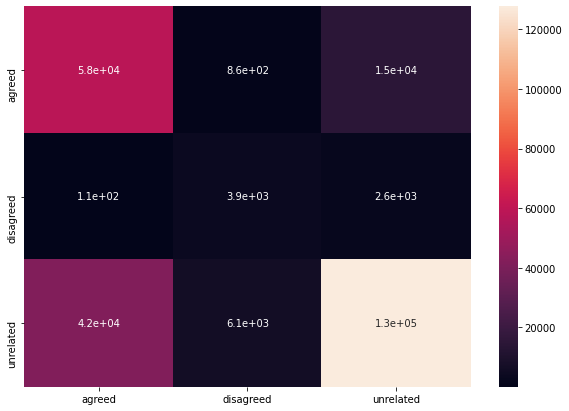

In [19]:
cm = confusion_matrix(train_data['label'].to_numpy().tolist(), pred_df['label'].to_numpy().tolist(), labels=['agreed', 'disagreed', 'unrelated'])
df_cm = pd.DataFrame(cm, index = ['agreed', 'disagreed', 'unrelated'], columns = ['agreed', 'disagreed', 'unrelated'])
print(df_cm)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [25]:
prfs = precision_recall_fscore_support(train_data['label'].to_numpy().tolist(), pred_df['label'].to_numpy().tolist(), labels=['agreed', 'disagreed', 'unrelated'], average=None)
prfs = np.array(prfs)
df_prfs = pd.DataFrame(prfs.T, index = ['agreed', 'disagreed', 'unrelated'], columns = ['precision', 'recall', 'fscore', 'support'])
print(df_prfs)

           precision    recall    fscore   support
agreed      0.582758  0.787993  0.670011   74238.0
disagreed   0.360369  0.596579  0.449322    6606.0
unrelated   0.879826  0.727132  0.796225  175598.0


# load testing data

In [8]:
test_data_file = f'{input_data_dir}\\test.csv'
test_data = pd.read_csv(f'{test_data_file}')

print(test_data.shape)

(64110, 5)


# test model

In [28]:
pred_df = nb.predict(test_dataset=test_data, alpha=ALPHA)
header = ['id','label']
pred_df.to_csv(f'{output_data_dir}\\submission_nb.csv', columns = header,index=False)